# This notebook was created to 1. collect (SNP & INDEL) variants in *eis* and the *eis* promoter, 2. detect instances of co-occurence of LoF variants in *eis* and the *eis* promoter and 3. analyze/date mutations on the lineage 2.2.1.1.1.i3 cluster phylogeny

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import vcf

%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from itertools import compress
from pylab import MaxNLocator
import seaborn as sns; sns.set()
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import ast
import itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import fastcluster
from sklearn import cluster, datasets
import scipy.cluster.hierarchy as hier
from sklearn.cluster import KMeans
import time
import sys
import pickle

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC
from Bio import Phylo

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
import itertools
import gzip

import networkx as nx
import scipy
from collections import Counter

# *eis*

promoter: 2,715,333 - 2,715,383

coding: 2,714,124 - 2,715,332

H37Rv region: 2,714,124 - 2,715,383

In [3]:
H37Rv_region_start = 2714124
H37Rv_region_end = 2715383
regulator_id = 'Rv2416c_Rv2417c'
regulon_id = 'Rv2416c'
gene_symbol = 'eis'

### *Function* to convert lineage-calls to new/simpler lineage call scheme

In [4]:
def convert_lineage_calls(isolate_annotation_DF):

    lineage_hierarchincal_to_lineage_map_df = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/CSV files/lineage_hierachical_to_lineage_map.csv')
    lineage_hierarchincal_to_lineage_map_series = pd.Series(list(lineage_hierarchincal_to_lineage_map_df.loc[:, 'lineage']), index = lineage_hierarchincal_to_lineage_map_df.lineage_hierarchical)

    lineage_call_update_list = []

    for hierarchical_lineage_call in isolate_annotation_DF.lineage_call:

        # if lineage call has an updated shorter call
        if hierarchical_lineage_call in lineage_hierarchincal_to_lineage_map_series.index:
            lineage_call_update_list.append(lineage_hierarchincal_to_lineage_map_series[hierarchical_lineage_call])

        # if lineage call doesn't have an updated shorter call
        else:
            lineage_call_update_list.append(hierarchical_lineage_call)

    # replace the hierarchical calls with the shorter ones
    isolate_annotation_DF.loc[:,'lineage_call'] = lineage_call_update_list
    
    return isolate_annotation_DF

# [1] INDELs

## [1.1] Load INDEL genotype matrix and Annotation Files

### 31,428 isolates

In [5]:
#load isolate annotation file (columns of Genotype Matrix)
INDEL_isolate_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape_indels/Genotypes_Filtered_2/genotypes_isolate_annotation.pkl')
INDEL_isolate_annotation_DF = INDEL_isolate_annotation_DF.loc[:, ['isolate_ID','lineage_call']] #drop columns
INDEL_isolate_annotation_DF = convert_lineage_calls(INDEL_isolate_annotation_DF)

#load INDEL annotation file (rows of Genotype Matrix) with gene annotation information
INDEL_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape_indels/Genotypes_Filtered_2/genotypes_INDEL_functional_annotation.pkl')
INDEL_annotation_DF.reset_index(inplace = True, drop = False)

#load Genotypes Matrix
INDEL_genotypes_array =  np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape_indels/Genotypes_Filtered_2/genotypes_matrix.npy')

In [6]:
INDEL_isolate_annotation_DF.head()

,isolate_ID,lineage_call
0,SAMN13051687,2.2.1.1.1.i3
1,SAMN09100245,4.3.i4.1
2,SAMN08732238,2.2.1.1.1
3,SAMN07658260,3.1.1
4,SAMN03648003,2.2.1.1.1


In [7]:
np.shape(INDEL_isolate_annotation_DF)

(31428, 2)

In [8]:
INDEL_annotation_DF.head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos
0,ACCGACGAAG_313_A,313,ACCGACGAAG,A,Essential,dnaA,Rv0001,313,del,inframe,105
1,TC_1549_T,1549,TC,T,None,None,Rv0001_Rv0002,None,del,frameshift,None
2,T_1552_TAA,1552,T,TAA,None,None,Rv0001_Rv0002,None,ins,frameshift,None
3,TAA_1552_T,1552,TAA,T,None,None,Rv0001_Rv0002,None,del,frameshift,None
4,T_1552_TA,1552,T,TA,None,None,Rv0001_Rv0002,None,ins,frameshift,None


In [9]:
np.shape(INDEL_annotation_DF)

(50260, 11)

In [10]:
INDEL_genotypes_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [11]:
np.shape(INDEL_genotypes_array)

(50260, 31428)

### additional 12 eis C-14T mutants with AG MICs

In [12]:
#load isolate annotation file (columns of Genotype Matrix)
isolate_annotation_DF_extra_strains = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/eis_promoter_mutant_strains_from_Milan/Genotypes/Genotypes_Filtered/genotypes_isolate_annotation.pkl')
isolate_annotation_DF_extra_strains = isolate_annotation_DF_extra_strains.loc[:, ['isolate_ID','lineage_call']]
isolate_annotation_DF_extra_strains = convert_lineage_calls(isolate_annotation_DF_extra_strains)

#load Genotypes Matrix
genotypes_array_extra_strains =  np.load('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/eis_promoter_mutant_strains_from_Milan/Genotypes_indels/Genotypes_Filtered/genotypes_matrix.npy')

In [13]:
isolate_annotation_DF_extra_strains.head()

,isolate_ID,lineage_call
0,168-19,2.2.1.1.1
1,622-19,2.2.1.1.1.i3
2,655-19,4.3.i3.1
3,IT1070,2.2.1.1.1.i3
4,IT123,2.2.1.1.1


In [14]:
genotypes_array_extra_strains

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 9, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [15]:
np.shape(genotypes_array_extra_strains)

(50260, 12)

### Merge *isolate annotation files* and *genotypes matrices* together

In [16]:
# merge isolate annotation dataframes
INDEL_isolate_annotation_DF = INDEL_isolate_annotation_DF.append(isolate_annotation_DF_extra_strains)
INDEL_isolate_annotation_DF.reset_index(inplace = True, drop = True)

In [17]:
np.shape(INDEL_isolate_annotation_DF)

(31440, 2)

In [18]:
# merge genotypes matrices
INDEL_genotypes_array = np.hstack((INDEL_genotypes_array, genotypes_array_extra_strains))

In [19]:
np.shape(INDEL_genotypes_array)

(50260, 31440)

## [1.2] Subset to targeted chomosomal region

In [20]:
# keep only indels that occur within chromosomal region
indels_in_targeted_region = list(INDEL_annotation_DF[(INDEL_annotation_DF.pos >= H37Rv_region_start) & (INDEL_annotation_DF.pos <= H37Rv_region_end)].key)

# construct boolean filter
indels_to_keep_filter = [indel_i in indels_in_targeted_region for indel_i in INDEL_annotation_DF.key]

# filter Genotypes Matrix
INDEL_genotypes_array = INDEL_genotypes_array[indels_to_keep_filter , :]

# filter INDEL annotation file
INDEL_annotation_DF = INDEL_annotation_DF[indels_to_keep_filter]
INDEL_annotation_DF.reset_index(drop = True , inplace = True) #re-index new filtered INDEL annotation DF (so new index matches indexing of genotypes matrix rows)

In [21]:
INDEL_annotation_DF.head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos
0,A_2714157_ACTG,2714157,A,ACTG,Non-Essential,eis,Rv2416c,1176,ins,inframe,392
1,T_2714272_TC,2714272,T,TC,Non-Essential,eis,Rv2416c,1061,ins,frameshift,354
2,C_2714303_CG,2714303,C,CG,Non-Essential,eis,Rv2416c,1030,ins,frameshift,344
3,G_2714334_GA,2714334,G,GA,Non-Essential,eis,Rv2416c,999,ins,frameshift,333
4,ACTCG_2714384_A,2714384,ACTCG,A,Non-Essential,eis,Rv2416c,949,del,frameshift,317


In [22]:
np.shape(INDEL_annotation_DF)

(28, 11)

In [23]:
INDEL_genotypes_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [24]:
np.shape(INDEL_genotypes_array)

(28, 31440)

# [2] SNPs

### 31,428 isolates

## [2.1] Load SNP genotype matrix and Annotation Files

In [25]:
#load isolate annotation file (columns of Genotype Matrix)
SNP_isolate_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_isolate_annotation.pkl')
SNP_isolate_annotation_DF = SNP_isolate_annotation_DF.loc[:, ['isolate_ID','lineage_call']] #drop columns
SNP_isolate_annotation_DF = convert_lineage_calls(SNP_isolate_annotation_DF)

#load INDEL annotation file (rows of Genotype Matrix) with gene annotation information
SNP_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_annotation.pkl')
SNP_annotation_DF = SNP_annotation_DF.loc[:, ['pos','ref','alt']] # drop columns
SNP_annotation_DF.reset_index(inplace = True, drop = False)

#load Genotypes Matrix
SNP_genotypes_array =  np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_matrix.npy')

In [26]:
SNP_isolate_annotation_DF.head()

,isolate_ID,lineage_call
0,SAMEA3558733,4.3.i4.2
1,SAMN03648641,4.4.1.1
2,SAMN03647419,3.1.1.i1
3,SAMEA3671418,4.3.i2
4,SAMN07659096,1.1.3


In [27]:
np.shape(SNP_isolate_annotation_DF)

(31428, 2)

In [28]:
SNP_annotation_DF.head()

,index,pos,ref,alt
0,0,48,C,[T]
1,1,64,G,[C]
2,2,67,G,"[A, T]"
3,3,69,C,[T]
4,4,71,C,[T]


In [29]:
np.shape(SNP_annotation_DF)

(782565, 4)

In [30]:
SNP_genotypes_array

array([[1, 1, 1, ..., 1, 1, 1],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [1, 9, 9, ..., 1, 1, 1],
       [1, 9, 1, ..., 1, 1, 1],
       [1, 9, 1, ..., 1, 1, 1]], dtype=int8)

In [31]:
np.shape(SNP_genotypes_array)

(782565, 31428)

### additional 12 eis C-14T mutants with AG MICs

In [32]:
#load isolate annotation file (columns of Genotype Matrix)
isolate_annotation_DF_extra_strains = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/eis_promoter_mutant_strains_from_Milan/Genotypes/Genotypes_Filtered/genotypes_isolate_annotation.pkl')
isolate_annotation_DF_extra_strains = isolate_annotation_DF_extra_strains.loc[:, ['isolate_ID','lineage_call']]
isolate_annotation_DF_extra_strains = convert_lineage_calls(isolate_annotation_DF_extra_strains)

#load Genotypes Matrix
genotypes_array_extra_strains =  np.load('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/eis_promoter_mutant_strains_from_Milan/Genotypes/Genotypes_Filtered/genotypes_matrix.npy')

In [33]:
isolate_annotation_DF_extra_strains.head()

,isolate_ID,lineage_call
0,168-19,2.2.1.1.1
1,622-19,2.2.1.1.1.i3
2,655-19,4.3.i3.1
3,IT1070,2.2.1.1.1.i3
4,IT123,2.2.1.1.1


In [34]:
genotypes_array_extra_strains

array([[1, 1, 1, ..., 1, 1, 1],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int8)

In [35]:
np.shape(genotypes_array_extra_strains)

(782565, 12)

### Merge *isolate annotation files* and *genotypes matrices* together

In [36]:
# merge isolate annotation dataframes
SNP_isolate_annotation_DF = SNP_isolate_annotation_DF.append(isolate_annotation_DF_extra_strains)
SNP_isolate_annotation_DF.reset_index(inplace = True, drop = True)

In [37]:
np.shape(SNP_isolate_annotation_DF)

(31440, 2)

In [38]:
# merge genotypes matrices
SNP_genotypes_array = np.hstack((SNP_genotypes_array, genotypes_array_extra_strains))

In [39]:
np.shape(SNP_genotypes_array)

(782565, 31440)

## [2.2] Subset to targeted chomosomal region

In [40]:
# keep only SNPs that occur within chromosomal region
SNPs_in_targeted_region = list(SNP_annotation_DF[(SNP_annotation_DF.pos >= H37Rv_region_start) & (SNP_annotation_DF.pos <= H37Rv_region_end)].pos)

# construct boolean filter
SNPs_to_keep_filter = [SNP_i in SNPs_in_targeted_region for SNP_i in SNP_annotation_DF.pos]

# filter Genotypes Matrix
SNP_genotypes_array = SNP_genotypes_array[SNPs_to_keep_filter , :]

# filter SNP annotation file
SNP_annotation_DF = SNP_annotation_DF[SNPs_to_keep_filter]
SNP_annotation_DF.reset_index(drop = True , inplace = True) #re-index new filtered SNP annotation DF (so new index matches indexing of genotypes matrix rows)
SNP_annotation_DF.loc[:,'array_index'] = SNP_annotation_DF.index

In [41]:
SNP_annotation_DF.head()

,index,pos,ref,alt,array_index
0,489761,2714130,C,[G],0
1,489762,2714139,G,[A],1
2,489763,2714140,G,[T],2
3,489764,2714145,G,[A],3
4,489765,2714147,C,[A],4


In [42]:
np.shape(SNP_annotation_DF)

(266, 5)

#### Re-format SNP annotation DataFrame so that each alternate allele is its own row

In [43]:
SNP_annotation_DF_mod = pd.DataFrame(columns = SNP_annotation_DF.columns)
new_SNP_index = 0
for SNP_i_row in SNP_annotation_DF.index:
    
    SNP_i_info = SNP_annotation_DF.loc[SNP_i_row, :]
    
    #iterate through alternate alleles, store a row for each one
    for SNP_i_alt_allele in SNP_i_info.alt:
        
        SNP_annotation_DF_mod.loc[new_SNP_index, :] = list(SNP_i_info.loc[['index','pos','ref']]) + [SNP_i_alt_allele] + list(SNP_i_info.loc[['array_index']])
        new_SNP_index += 1

SNP_annotation_DF = SNP_annotation_DF_mod
#create new column to merge func annotation on
SNP_annotation_DF.loc[:, 'key'] = [str(SNP_i_pos) + '_' + SNP_i_alt for SNP_i_pos, SNP_i_alt in zip(SNP_annotation_DF.pos, SNP_annotation_DF.alt)]

In [44]:
SNP_annotation_DF.head()

,index,pos,ref,alt,array_index,key
0,489761,2714130,C,G,0,2714130_G
1,489762,2714139,G,A,1,2714139_A
2,489763,2714140,G,T,2,2714140_T
3,489764,2714145,G,A,3,2714145_A
4,489765,2714147,C,A,4,2714147_A


In [45]:
np.shape(SNP_annotation_DF)

(284, 6)

#### Merge functional annotation data

In [46]:
SNP_func_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_functional_annotation.pkl')
SNP_func_annotation_DF.loc[:, 'key'] = SNP_func_annotation_DF.index

In [47]:
SNP_func_annotation_DF.head()

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,SNP_type,AA_change,key
48_T,48,C,T,Essential,dnaA,Rv0001,48,S,V16V,48_T
64_C,64,G,C,Essential,dnaA,Rv0001,64,N,G22R,64_C
67_A,67,G,A,Essential,dnaA,Rv0001,67,N,D23N,67_A
67_T,67,G,T,Essential,dnaA,Rv0001,67,N,D23Y,67_T
69_T,69,C,T,Essential,dnaA,Rv0001,69,S,D23D,69_T


In [48]:
SNP_annotation_DF = SNP_annotation_DF.merge(SNP_func_annotation_DF.loc[: , ['gene_category','gene_name','gene_id','gene_pos','SNP_type','AA_change','key']], how = 'left', on = 'key')
SNP_annotation_DF = SNP_annotation_DF.loc[:, ['key','pos','ref','alt','gene_category','gene_name','gene_id','gene_pos','SNP_type','AA_change','array_index']] #re-arrange columns
SNP_annotation_DF.rename(columns={'SNP_type':'mut_type', 'AA_change':'codon_pos'}, inplace = True) #change column names

In [49]:
SNP_annotation_DF.head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,mut_type,codon_pos,array_index
0,2714130_G,2714130,C,G,Non-Essential,eis,Rv2416c,1203,N,E401D,0
1,2714139_A,2714139,G,A,Non-Essential,eis,Rv2416c,1194,S,T398T,1
2,2714140_T,2714140,G,T,Non-Essential,eis,Rv2416c,1193,N,T398N,2
3,2714145_A,2714145,G,A,Non-Essential,eis,Rv2416c,1188,S,V396V,3
4,2714147_A,2714147,C,A,Non-Essential,eis,Rv2416c,1186,N,V396F,4


In [50]:
np.shape(SNP_annotation_DF)

(284, 11)

In [51]:
SNP_genotypes_array

array([[1, 1, 1, ..., 1, 1, 1],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [52]:
np.shape(SNP_genotypes_array)

(266, 31440)

# [3] Pull info for isolates with mutant alleles

## [3.1] Get genotypes for SNPs of interest

### *Function* to get the genotypes for a specifc SNP and get attributes for isolates that support SNP

In [53]:
def get_genotypes_for_SNP(SNP_i_pos, SNP_i_alt_allele):
    
    #get the number code that corresponds to the alt allele, 9 indicated bad quality call
    base_code_dict = {'A':0, 'C':1, 'G':2, 'T':3}
    SNP_i_alt_allele_code = base_code_dict[SNP_i_alt_allele]
    SNP_i_genotypes = SNP_genotypes_array[SNP_annotation_DF[SNP_annotation_DF.pos == SNP_i_pos].array_index.values[0] , :] 

    #count the number of isolates that support this SNP call
    num_isolates_SNP_i = np.sum(SNP_i_genotypes == SNP_i_alt_allele_code)

    #create a boolean filter and extract information for the isolates that support this call
    SNP_i_isolate_filter = SNP_i_genotypes == SNP_i_alt_allele_code
    isolate_annotation_SNP_i = SNP_isolate_annotation_DF[SNP_i_isolate_filter]

    #find number of sub-lineages that have SNP support in at least 1 isolate
    num_sublineages_with_SNP_i = len(set(list(isolate_annotation_SNP_i.lineage_call.values)))
    
    #get list of sublineages w/ at least 1 isolates that supports SNP call
    sublineages_with_SNP_count_dict = Counter(isolate_annotation_SNP_i.lineage_call.values)
    sublineages_with_SNP_list = []
    for sublineage_i in sublineages_with_SNP_count_dict.keys():

        sublineage_i_with_SNP = sublineage_i + '({0})'.format(str(sublineages_with_SNP_count_dict[sublineage_i]))
        sublineages_with_SNP_list.append(sublineage_i_with_SNP)

    sublineages_with_SNP = ' - '.join(sublineages_with_SNP_list)

    return [num_isolates_SNP_i , num_sublineages_with_SNP_i , sublineages_with_SNP]

In [54]:
SNP_annotation_DF.head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,mut_type,codon_pos,array_index
0,2714130_G,2714130,C,G,Non-Essential,eis,Rv2416c,1203,N,E401D,0
1,2714139_A,2714139,G,A,Non-Essential,eis,Rv2416c,1194,S,T398T,1
2,2714140_T,2714140,G,T,Non-Essential,eis,Rv2416c,1193,N,T398N,2
3,2714145_A,2714145,G,A,Non-Essential,eis,Rv2416c,1188,S,V396V,3
4,2714147_A,2714147,C,A,Non-Essential,eis,Rv2416c,1186,N,V396F,4


In [55]:
np.shape(SNP_annotation_DF)

(284, 11)

In [56]:
num_isolates_with_SNP = []
num_sublineages_with_SNP = []
sublineages_with_SNP = []

for SNP_i_pos, SNP_i_alt_allele in zip(SNP_annotation_DF.pos, SNP_annotation_DF.alt):
    
    num_isolates_with_SNP_i , num_sublineages_with_SNP_i , sublineages_with_SNP_i = get_genotypes_for_SNP(SNP_i_pos, SNP_i_alt_allele)
    
    num_isolates_with_SNP.append(num_isolates_with_SNP_i)
    num_sublineages_with_SNP.append(num_sublineages_with_SNP_i)
    sublineages_with_SNP.append(sublineages_with_SNP_i)
    
SNP_annotation_DF.loc[: , 'num_isolates'] = num_isolates_with_SNP
SNP_annotation_DF.loc[: , 'num_sublineages'] = num_sublineages_with_SNP
SNP_annotation_DF.loc[: , 'sublineages'] = sublineages_with_SNP

#drop SNPs present in 0 isolates
SNP_annotation_DF = SNP_annotation_DF[SNP_annotation_DF.num_isolates > 0]
SNP_annotation_DF.reset_index(inplace = True, drop = True)

In [57]:
SNP_annotation_DF.head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,mut_type,codon_pos,array_index,num_isolates,num_sublineages,sublineages
0,2714130_G,2714130,C,G,Non-Essential,eis,Rv2416c,1203,N,E401D,0,27,2,3.1.1(25) - 3.1(2)
1,2714139_A,2714139,G,A,Non-Essential,eis,Rv2416c,1194,S,T398T,1,1,1,4.1.i1.1.1.1(1)
2,2714140_T,2714140,G,T,Non-Essential,eis,Rv2416c,1193,N,T398N,2,2,1,1.1.1.1(2)
3,2714145_A,2714145,G,A,Non-Essential,eis,Rv2416c,1188,S,V396V,3,2,2,4.5(1) - 4.13(1)
4,2714147_A,2714147,C,A,Non-Essential,eis,Rv2416c,1186,N,V396F,4,1,1,1.1.3(1)


In [58]:
np.shape(SNP_annotation_DF)

(283, 14)

## [3.2] Get genotypes for indels of interest

### *Function* to get the genotypes for a specifc indel and get attributes for isolates that support indel

In [59]:
def get_genotypes_for_indel(indel_i_key):
    
    #0 supports Ref, 1 supports Alt, 9 indicated bad quality call
    indel_i_genotypes = INDEL_genotypes_array[INDEL_annotation_DF[INDEL_annotation_DF.key == indel_i_key].index[0] , :] 

    #count the number of isolates that support this indel call
    num_isolates_indel_i = np.sum(indel_i_genotypes == 1)

    #create a boolean filter and extract information for the isolates taht support this call
    indel_i_isolate_filter = indel_i_genotypes == 1
    isolate_annotation_indel_i = INDEL_isolate_annotation_DF[indel_i_isolate_filter]

    #find number of sub-lineages that have indel support in at least 1 isolate
    num_sublineages_with_indel_i = len(set(list(isolate_annotation_indel_i.lineage_call.values)))
    
    #get list of sublineages w/ at least 1 isolates that supports indel call
    sublineage_with_indel_count_dict = Counter(isolate_annotation_indel_i.lineage_call.values)
    sublineages_with_indel_list = []
    for sublineage_i in sublineage_with_indel_count_dict.keys():

        sublineage_i_with_indel = sublineage_i + '({0})'.format(str(sublineage_with_indel_count_dict[sublineage_i]))
        sublineages_with_indel_list.append(sublineage_i_with_indel)

    sublineages_with_indel = ' - '.join(sublineages_with_indel_list)
    
    return [num_isolates_indel_i , num_sublineages_with_indel_i , sublineages_with_indel]

In [60]:
INDEL_annotation_DF.head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos
0,A_2714157_ACTG,2714157,A,ACTG,Non-Essential,eis,Rv2416c,1176,ins,inframe,392
1,T_2714272_TC,2714272,T,TC,Non-Essential,eis,Rv2416c,1061,ins,frameshift,354
2,C_2714303_CG,2714303,C,CG,Non-Essential,eis,Rv2416c,1030,ins,frameshift,344
3,G_2714334_GA,2714334,G,GA,Non-Essential,eis,Rv2416c,999,ins,frameshift,333
4,ACTCG_2714384_A,2714384,ACTCG,A,Non-Essential,eis,Rv2416c,949,del,frameshift,317


In [61]:
np.shape(INDEL_annotation_DF)

(28, 11)

In [62]:
num_isolates_with_indel = []
num_sublineages_with_indel = []
sublineages_with_indel = []

for indel_i_key in INDEL_annotation_DF.key:
    
    num_isolates_with_indel_i , num_sublineages_with_indel_i , sublineages_with_indel_i = get_genotypes_for_indel(indel_i_key)
    
    num_isolates_with_indel.append(num_isolates_with_indel_i)
    num_sublineages_with_indel.append(num_sublineages_with_indel_i)
    sublineages_with_indel.append(sublineages_with_indel_i)
    
INDEL_annotation_DF.loc[: , 'num_isolates'] = num_isolates_with_indel
INDEL_annotation_DF.loc[: , 'num_sublineages'] = num_sublineages_with_indel
INDEL_annotation_DF.loc[: , 'sublineages'] = sublineages_with_indel

#drop indels present in 0 isolates
INDEL_annotation_DF = INDEL_annotation_DF[INDEL_annotation_DF.num_isolates > 0]

In [63]:
INDEL_annotation_DF.head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,num_isolates,num_sublineages,sublineages
2,C_2714303_CG,2714303,C,CG,Non-Essential,eis,Rv2416c,1030,ins,frameshift,344,3,1,4.1.i1.1.1.1(3)
3,G_2714334_GA,2714334,G,GA,Non-Essential,eis,Rv2416c,999,ins,frameshift,333,1,1,3.1.1(1)
4,ACTCG_2714384_A,2714384,ACTCG,A,Non-Essential,eis,Rv2416c,949,del,frameshift,317,4,1,4.4.1.1(4)
5,GT_2714433_G,2714433,GT,G,Non-Essential,eis,Rv2416c,900,del,frameshift,300,2,1,4.1.i1.2.1(2)
6,GGT_2714526_G,2714526,GGT,G,Non-Essential,eis,Rv2416c,807,del,frameshift,269,112,1,2.2.1.1.1(112)


In [64]:
np.shape(INDEL_annotation_DF)

(24, 14)

# [4] Check co-occurrence between *regulator* SNPs/INDELs & *regulon* SNPs/INDELs

### SNPs in regulator

In [65]:
regulator_SNPs_DF = SNP_annotation_DF[SNP_annotation_DF.gene_id == regulator_id]

In [66]:
regulator_SNPs_DF.head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,mut_type,codon_pos,array_index,num_isolates,num_sublineages,sublineages
263,2715333_C,2715333,A,C,None,None,Rv2416c_Rv2417c,None,I,None,249,2,2,4.3.i3.1(1) - 1.1.1.1(1)
264,2715337_C,2715337,T,C,None,None,Rv2416c_Rv2417c,None,I,None,250,1,1,3.1.1(1)
265,2715338_A,2715338,C,A,None,None,Rv2416c_Rv2417c,None,I,None,251,2,1,4.3.i4.1(2)
266,2715340_A,2715340,G,A,None,None,Rv2416c_Rv2417c,None,I,None,252,9,3,4.3.i4.1(1) - 4.1.i1.1.1.1(7) - 2.2.1.1.2(1)
267,2715340_T,2715340,G,T,None,None,Rv2416c_Rv2417c,None,I,None,252,11,4,4.11(2) - 2.2.1.1.1.i3(5) - 4.3.i3.1(3) - 2.2....


In [67]:
np.shape(regulator_SNPs_DF)

(20, 14)

### INDELs in regulator

In [68]:
regulator_INDELs_DF = INDEL_annotation_DF[INDEL_annotation_DF.gene_id == regulator_id]

In [69]:
regulator_INDELs_DF.head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,num_isolates,num_sublineages,sublineages
25,GAATCCGAC_2715334_G,2715334,GAATCCGAC,G,None,None,Rv2416c_Rv2417c,None,del,frameshift,None,1,1,2.2.1.1.1.i3(1)
26,CG_2715339_C,2715339,CG,C,None,None,Rv2416c_Rv2417c,None,del,frameshift,None,7,3,2.2.1.1.1.i3(1) - 2.2.1.1.1(5) - 4.4.2(1)
27,AC_2715362_A,2715362,AC,A,None,None,Rv2416c_Rv2417c,None,del,frameshift,None,1,1,4.3.i3.2(1)


In [70]:
np.shape(regulator_INDELs_DF)

(3, 14)

Drop **INDEL_type** column and rename **ins_del** column to fit with SNPs DataFrames

In [71]:
regulator_INDELs_DF.drop(['INDEL_type'], axis=1, inplace = True)
regulator_INDELs_DF.rename(columns={'ins_del':'mut_type'}, inplace = True) #change column names

/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/rv76/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


### SNPs in regulon

We're going to include SNPs in a gene that either 

- cause a **premature STOP codon** (nonsense mutation)
- **synonymous mutations at the first codon that abolish the start codon** (i.e. eis, whiB7 and mmpR which start with a **valine** as this is not possible with ahpC, mmpS5 or mmpL5, which start with a **methionine**)
- **non-synonymous mutations at the first codon that abolish the start codon** (i.e. that change the start to an AA other than **valine** and **methionine**)

In [72]:
regulon_SNPs_DF = SNP_annotation_DF[SNP_annotation_DF.gene_id == regulon_id]

In [73]:
regulon_SNPs_DF[[(AA_change[-1]=='*') | ((len(AA_change)==3) and (AA_change[1]=='1')) for AA_change in regulon_SNPs_DF.codon_pos]]

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,mut_type,codon_pos,array_index,num_isolates,num_sublineages,sublineages
59,2714449_T,2714449,C,T,Non-Essential,eis,Rv2416c,884,N,W295*,57,1,1,3.1.1(1)
82,2714543_A,2714543,G,A,Non-Essential,eis,Rv2416c,790,N,R264*,79,1,1,3.1.1(1)
103,2714664_T,2714664,G,T,Non-Essential,eis,Rv2416c,669,N,Y223*,99,2,1,3.1.1(2)
123,2714753_A,2714753,G,A,Non-Essential,eis,Rv2416c,580,N,Q194*,118,10,2,4.10.i1(1) - 1.2.2.1(9)
132,2714787_T,2714787,C,T,Non-Essential,eis,Rv2416c,546,N,W182*,126,15,1,4.10.i1(15)
244,2715294_T,2715294,C,T,Non-Essential,eis,Rv2416c,39,N,W13*,232,1,1,2.2.1.1.1(1)
245,2715295_T,2715295,C,T,Non-Essential,eis,Rv2416c,38,N,W13*,233,1,1,2.2.1.1.1(1)
249,2715305_A,2715305,C,A,Non-Essential,eis,Rv2416c,28,N,E10*,237,6,2,1.1.3(5) - 1.1.1.1(1)
262,2715330_T,2715330,C,T,Non-Essential,eis,Rv2416c,3,S,V1V,248,6,2,2.2.1.1.1.i3(5) - 1.1.1.1(1)


In [74]:
regulon_SNPs_DF = regulon_SNPs_DF[[(AA_change[-1]=='*') | ((len(AA_change)==3) and (AA_change[1]=='1')) for AA_change in regulon_SNPs_DF.codon_pos]]

Save SNPs that occur in the first codon seperately

In [75]:
regulon_SNPs_DF[[((len(AA_change)==3) and (AA_change[1]=='1')) for AA_change in regulon_SNPs_DF.codon_pos]].to_excel('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/CSV files/START_codon_SNVs/eis_START_codon_SNVs.xlsx')

### INDELs in regulon

#### keep only *frameshift* indels for gene body

In [76]:
INDEL_annotation_DF[(INDEL_annotation_DF.gene_id == regulon_id) & (INDEL_annotation_DF.INDEL_type == 'frameshift')].head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,num_isolates,num_sublineages,sublineages
2,C_2714303_CG,2714303,C,CG,Non-Essential,eis,Rv2416c,1030,ins,frameshift,344,3,1,4.1.i1.1.1.1(3)
3,G_2714334_GA,2714334,G,GA,Non-Essential,eis,Rv2416c,999,ins,frameshift,333,1,1,3.1.1(1)
4,ACTCG_2714384_A,2714384,ACTCG,A,Non-Essential,eis,Rv2416c,949,del,frameshift,317,4,1,4.4.1.1(4)
5,GT_2714433_G,2714433,GT,G,Non-Essential,eis,Rv2416c,900,del,frameshift,300,2,1,4.1.i1.2.1(2)
6,GGT_2714526_G,2714526,GGT,G,Non-Essential,eis,Rv2416c,807,del,frameshift,269,112,1,2.2.1.1.1(112)


In [77]:
regulon_INDELs_DF = INDEL_annotation_DF[(INDEL_annotation_DF.gene_id == regulon_id) & (INDEL_annotation_DF.INDEL_type == 'frameshift')]

In [78]:
regulon_INDELs_DF.head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,num_isolates,num_sublineages,sublineages
2,C_2714303_CG,2714303,C,CG,Non-Essential,eis,Rv2416c,1030,ins,frameshift,344,3,1,4.1.i1.1.1.1(3)
3,G_2714334_GA,2714334,G,GA,Non-Essential,eis,Rv2416c,999,ins,frameshift,333,1,1,3.1.1(1)
4,ACTCG_2714384_A,2714384,ACTCG,A,Non-Essential,eis,Rv2416c,949,del,frameshift,317,4,1,4.4.1.1(4)
5,GT_2714433_G,2714433,GT,G,Non-Essential,eis,Rv2416c,900,del,frameshift,300,2,1,4.1.i1.2.1(2)
6,GGT_2714526_G,2714526,GGT,G,Non-Essential,eis,Rv2416c,807,del,frameshift,269,112,1,2.2.1.1.1(112)


In [79]:
np.shape(regulon_INDELs_DF)

(18, 14)

Drop **INDEL_type** column (since all indels are frameshifts) and rename **ins_del** column to fit with SNPs DataFrames

In [80]:
regulon_INDELs_DF.drop(['INDEL_type'], axis=1, inplace = True)
regulon_INDELs_DF.rename(columns={'ins_del':'mut_type'}, inplace = True) #change column names

/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Save DataFrame for *regulator* & *regulon* mutations

In [81]:
regulator_SNPs_DF_for_export = regulator_SNPs_DF.drop(['array_index'], axis=1)
regulon_SNPs_DF_for_export = regulon_SNPs_DF.drop(['array_index'], axis=1)
regulator_regulon_mutations_df = regulator_SNPs_DF_for_export.append(regulon_SNPs_DF_for_export.append(regulator_INDELs_DF.append(regulon_INDELs_DF)))

regulator_regulon_mutations_df.drop(['key'], axis=1, inplace = True) #drop col
regulator_regulon_mutations_df.sort_values(by = 'pos', inplace = True) #sort by reference position
regulator_regulon_mutations_df.reset_index(inplace = True, drop = True) #reset index

In [82]:
np.shape(regulator_regulon_mutations_df)

(50, 12)

In [83]:
regulator_regulon_mutations_df

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,mut_type,codon_pos,num_isolates,num_sublineages,sublineages
0,2714303,C,CG,Non-Essential,eis,Rv2416c,1030,ins,344,3,1,4.1.i1.1.1.1(3)
1,2714334,G,GA,Non-Essential,eis,Rv2416c,999,ins,333,1,1,3.1.1(1)
2,2714384,ACTCG,A,Non-Essential,eis,Rv2416c,949,del,317,4,1,4.4.1.1(4)
3,2714433,GT,G,Non-Essential,eis,Rv2416c,900,del,300,2,1,4.1.i1.2.1(2)
4,2714449,C,T,Non-Essential,eis,Rv2416c,884,N,W295*,1,1,3.1.1(1)
5,2714526,GGT,G,Non-Essential,eis,Rv2416c,807,del,269,112,1,2.2.1.1.1(112)
6,2714543,G,A,Non-Essential,eis,Rv2416c,790,N,R264*,1,1,3.1.1(1)
7,2714557,AGGCCAATCAG,A,Non-Essential,eis,Rv2416c,776,del,259,1,1,2.2.1.1.1(1)
8,2714664,G,T,Non-Essential,eis,Rv2416c,669,N,Y223*,2,1,3.1.1(2)
9,2714740,TC,T,Non-Essential,eis,Rv2416c,593,del,198,2,1,1.1.2(2)


In [84]:
regulator_regulon_mutations_df.to_excel('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/CSV files/mutations_detected_within_isolates/promoter_eis_gene_body_mutations_in_31440_isolates.xlsx')

#### Save DataFrame for *regulator* & *regulon* mutations for *Table 1*

**REGULATOR** Subset to the 4 most commonly occurring mutations in the regulator regions

In [85]:
regulator_mutations_df_subset = regulator_regulon_mutations_df[regulator_regulon_mutations_df.gene_id == regulator_id].sort_values(by = 'num_isolates', ascending = False).head(n=4)

**REGULON** Subset to mutations that occured in at least 2 Mtb sub-lineages in the regulon regions

In [87]:
regulon_mutations_df_subset = regulator_regulon_mutations_df[regulator_regulon_mutations_df.gene_id == regulon_id]
regulon_mutations_df_subset = regulon_mutations_df_subset[regulon_mutations_df_subset.num_sublineages >= 2]

Export as excel file

In [90]:
regulator_regulon_subset_mutations_df = regulator_mutations_df_subset.append(regulon_mutations_df_subset)
regulator_regulon_subset_mutations_df.sort_values(by = 'pos', ascending = True, inplace = True)
regulator_regulon_subset_mutations_df.reset_index(inplace = True, drop = True)

In [91]:
regulator_regulon_subset_mutations_df

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,mut_type,codon_pos,num_isolates,num_sublineages,sublineages
0,2714753,G,A,Non-Essential,eis,Rv2416c,580,N,Q194*,10,2,4.10.i1(1) - 1.2.2.1(9)
1,2715287,T,TC,Non-Essential,eis,Rv2416c,46,ins,16,3,2,4.4.1.1(1) - 4.3.i2(2)
2,2715305,C,A,Non-Essential,eis,Rv2416c,28,N,E10*,6,2,1.1.3(5) - 1.1.1.1(1)
3,2715330,C,T,Non-Essential,eis,Rv2416c,3,S,V1V,6,2,2.2.1.1.1.i3(5) - 1.1.1.1(1)
4,2715342,C,T,None,None,Rv2416c_Rv2417c,None,I,None,293,18,4.11(1) - 2.2.1.1.1.i3(58) - 4.3.i3.1(14) - 4....
5,2715344,G,A,None,None,Rv2416c_Rv2417c,None,I,None,332,17,4.10.i2(1) - 2.2.1.1.1.i3(70) - 4.3.i3.1(50) -...
6,2715346,G,A,None,None,Rv2416c_Rv2417c,None,I,None,181,19,2.2.1.1.1.i3(89) - 4.3.i3.1(18) - 4.10.i2(4) -...
7,2715369,C,A,None,None,Rv2416c_Rv2417c,None,I,None,285,8,4.11(4) - 2.2.1.1.1.i3(230) - 4.1.i1.1.1.1(1) ...


In [92]:
regulator_regulon_subset_mutations_df.to_excel('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/CSV files/mutations_detected_within_isolates/promoter_eis_gene_body_mutations_in_31440_isolates_for_Table_1.xlsx')

### Construct DataFrame (which displays each pair of co-occuring mutations as a seperate row with info for each pair of mutations)

In [85]:
variant_mutation_pair_df = pd.DataFrame(columns=['A_type', 'A_pos', 'A_ref', 'A_alt', 'A_mut_type', 'A_codon_pos', 'A_gene_id', 'A_gene_name', 'A_gene_pos' ,'A_num_isolates', 'B_type', 'B_pos', 'B_ref', 'B_alt', 'B_mut_type', 'B_codon_pos', 'B_gene_id', 'B_gene_name', 'B_gene_pos', 'B_num_isolates', 'num_isolates_co_occur', 'isolate_IDs', 'sublineages'])

### Get the ordering of the INDELs genotypes columns in terms of the SNPs genotypes columns

In [86]:
SNP_isolate_annotation_DF['isolate_order'] = SNP_isolate_annotation_DF.index
SNP_isolate_annotation_DF.set_index('isolate_ID', drop = True, inplace = True)
INDEL_isolate_ordering_for_SNP_genotypes_array = SNP_isolate_annotation_DF.loc[INDEL_isolate_annotation_DF.isolate_ID, :].isolate_order.values

In [87]:
INDEL_isolate_ordering_for_SNP_genotypes_array

array([  188,  2733, 24409, ..., 31437, 31438, 31439])

### Fill in dataframe by quering the genotypes matrices

In [88]:
#SNPs or INDELs in regulator x SNPs or INDELs in regulon
regulator_mut_keys = list(regulator_SNPs_DF.key) + list(regulator_INDELs_DF.key)
regulon_mut_keys = list(regulon_SNPs_DF.key) + list(regulon_INDELs_DF.key)

In [89]:
#index for DataFrame
variant_mutation_pair_df_index = 0

for variant_i in regulator_mut_keys: #iterate through regulator SNPs & INDELs
    
    if variant_i.count('_') == 1: # if variant in regulator is a SNP

        SNP_i_pos = int(variant_i.split('_')[0])
        SNP_i_alt_allele = variant_i.split('_')[1]

        #get the number code that corresponds to the alt allele, 9 indicated bad quality call
        base_code_dict = {'A':0, 'C':1, 'G':2, 'T':3}
        SNP_i_alt_allele_code = base_code_dict[SNP_i_alt_allele]

        #genotypes for each SNP site
        genotypes_for_SNP_i = SNP_genotypes_array[SNP_annotation_DF[SNP_annotation_DF.pos == SNP_i_pos].array_index.values[0] , :]

        #re-order isolates according to the order of the columns in the INDEL genotypes matrix
        genotypes_for_SNP_i = genotypes_for_SNP_i[INDEL_isolate_ordering_for_SNP_genotypes_array]

        for variant_j in regulon_mut_keys: #iterate through mutations in regulon

            if variant_j.count('_') == 1: #if variant in regulon is a SNP

                SNP_j_pos = int(variant_j.split('_')[0])
                SNP_j_alt_allele = variant_j.split('_')[1]

                #get the number code that corresponds to the alt allele, 9 indicated bad quality call
                SNP_j_alt_allele_code = base_code_dict[SNP_j_alt_allele]

                #genotypes for each SNP site
                genotypes_for_SNP_j = SNP_genotypes_array[SNP_annotation_DF[SNP_annotation_DF.pos == SNP_j_pos].array_index.values[0] , :]

                #re-order isolates according to the order of the columns in the INDEL genotypes matrix
                genotypes_for_SNP_j = genotypes_for_SNP_j[INDEL_isolate_ordering_for_SNP_genotypes_array]

                #boolean filter of isolates with both variants
                isolates_with_both_variants_filter = [(SNP_i_called and SNP_j_called) for SNP_i_called , SNP_j_called in zip(list(genotypes_for_SNP_i == SNP_i_alt_allele_code) , list(genotypes_for_SNP_j == SNP_j_alt_allele_code))]

                #number of isolates that have both variants
                num_isolates_with_both_variants = np.sum(isolates_with_both_variants_filter)

                #check to see if the number of isolates carrying both variants was >= 1
                if num_isolates_with_both_variants >= 1:

                    # get info for mutation in regulator
                    regulator_SNP_info = list(regulator_SNPs_DF[(regulator_SNPs_DF.pos == SNP_i_pos) & (regulator_SNPs_DF.alt == SNP_i_alt_allele)].loc[:, ['pos','ref','alt','mut_type','codon_pos','gene_id','gene_name','gene_pos','num_isolates']].values[0])

                    # get info for mutation in regulon
                    regulon_SNP_info = list(regulon_SNPs_DF[(regulon_SNPs_DF.pos == SNP_j_pos) & (regulon_SNPs_DF.alt == SNP_j_alt_allele)].loc[:, ['pos','ref','alt','mut_type','codon_pos','gene_id','gene_name','gene_pos','num_isolates']].values[0])

                    strain_names = [' - '.join(list(INDEL_isolate_annotation_DF[isolates_with_both_variants_filter].isolate_ID))]

                    # sublineage calls
                    strain_lineage_calls_count_dict = Counter(list(INDEL_isolate_annotation_DF[isolates_with_both_variants_filter].lineage_call))
                    strain_lineage_calls_list = []
                    for sublineage_i in strain_lineage_calls_count_dict.keys():
                        sublineage_i_with_mutations = sublineage_i + '({0})'.format(str(strain_lineage_calls_count_dict[sublineage_i]))
                        strain_lineage_calls_list.append(sublineage_i_with_mutations)
                    strain_lineage_calls = ' - '.join(strain_lineage_calls_list)

                    co_occurring_SNP_i_and_SNP_or_indel_j_info = ['SNP'] + regulator_SNP_info + ['SNP'] + regulon_SNP_info + [num_isolates_with_both_variants] + strain_names + [strain_lineage_calls]
                    variant_mutation_pair_df.loc[variant_mutation_pair_df_index, :] = co_occurring_SNP_i_and_SNP_or_indel_j_info
                    variant_mutation_pair_df_index += 1

            if variant_j.count('_') == 2: #if variant in regulon is an INDEL

                #genotypes for each INDEL
                genotypes_for_indel_j = INDEL_genotypes_array[INDEL_annotation_DF[INDEL_annotation_DF.key == variant_j].index[0] , :]

                #boolean filter of isolates with both variants
                isolates_with_both_variants_filter = [(SNP_i_called and indel_j_called) for SNP_i_called , indel_j_called in zip(list(genotypes_for_SNP_i == SNP_i_alt_allele_code) , list(genotypes_for_indel_j == 1))]

                #number of isolates that have both variants
                num_isolates_with_both_variants = np.sum(isolates_with_both_variants_filter)

                #check to see if the number of isolates carrying both variants was >= 1
                if num_isolates_with_both_variants >= 1:

                    # get info for mutation in regulator
                    regulator_SNP_info = list(regulator_SNPs_DF[(regulator_SNPs_DF.pos == SNP_i_pos) & (regulator_SNPs_DF.alt == SNP_i_alt_allele)].loc[:, ['pos','ref','alt','mut_type','codon_pos','gene_id','gene_name','gene_pos','num_isolates']].values[0])

                    # get info for mutation in regulon
                    regulon_INDEL_info = list(regulon_INDELs_DF[regulon_INDELs_DF.key == variant_j].loc[:, ['pos','ref','alt','mut_type','codon_pos','gene_id','gene_name','gene_pos','num_isolates']].values[0])

                    strain_names = [' - '.join(list(INDEL_isolate_annotation_DF[isolates_with_both_variants_filter].isolate_ID))]

                    # sublineage calls
                    strain_lineage_calls_count_dict = Counter(list(INDEL_isolate_annotation_DF[isolates_with_both_variants_filter].lineage_call))
                    strain_lineage_calls_list = []
                    for sublineage_i in strain_lineage_calls_count_dict.keys():
                        sublineage_i_with_mutations = sublineage_i + '({0})'.format(str(strain_lineage_calls_count_dict[sublineage_i]))
                        strain_lineage_calls_list.append(sublineage_i_with_mutations)
                    strain_lineage_calls = ' - '.join(strain_lineage_calls_list)

                    co_occurring_SNP_i_and_SNP_or_indel_j_info = ['SNP'] + regulator_SNP_info + ['INDEL'] + regulon_INDEL_info + [num_isolates_with_both_variants] + strain_names + [strain_lineage_calls]
                    variant_mutation_pair_df.loc[variant_mutation_pair_df_index, :] = co_occurring_SNP_i_and_SNP_or_indel_j_info
                    variant_mutation_pair_df_index += 1
    
    elif variant_i.count('_') == 2: # if variant in regulator is an INDEL
        
        #genotypes for each INDEL
        genotypes_for_indel_i = INDEL_genotypes_array[INDEL_annotation_DF[INDEL_annotation_DF.key == variant_i].index[0] , :]

        for variant_j in regulon_mut_keys: #iterate through mutations in regulon

            if variant_j.count('_') == 1: #if variant in regulon is a SNP

                SNP_j_pos = int(variant_j.split('_')[0])
                SNP_j_alt_allele = variant_j.split('_')[1]

                #get the number code that corresponds to the alt allele, 9 indicated bad quality call
                SNP_j_alt_allele_code = base_code_dict[SNP_j_alt_allele]

                #genotypes for each SNP site
                genotypes_for_SNP_j = SNP_genotypes_array[SNP_annotation_DF[SNP_annotation_DF.pos == SNP_j_pos].array_index.values[0] , :]

                #re-order isolates according to the order of the columns in the INDEL genotypes matrix
                genotypes_for_SNP_j = genotypes_for_SNP_j[INDEL_isolate_ordering_for_SNP_genotypes_array]

                #boolean filter of isolates with both variants
                isolates_with_both_variants_filter = [(indel_i_called and SNP_j_called) for indel_i_called , SNP_j_called in zip(list(genotypes_for_indel_i == 1) , list(genotypes_for_SNP_j == SNP_j_alt_allele_code))]

                #number of isolates that have both variants
                num_isolates_with_both_variants = np.sum(isolates_with_both_variants_filter)

                #check to see if the number of isolates carrying both variants was >= 1
                if num_isolates_with_both_variants >= 1:

                    # get info for mutation in regulator
                    regulator_INDEL_info = list(regulator_INDELs_DF[regulator_INDELs_DF.key == variant_i].loc[:, ['pos','ref','alt','mut_type','codon_pos','gene_id','gene_name','gene_pos','num_isolates']].values[0])

                    # get info for mutation in regulon
                    regulon_SNP_info = list(regulon_SNPs_DF[(regulon_SNPs_DF.pos == SNP_j_pos) & (regulon_SNPs_DF.alt == SNP_j_alt_allele)].loc[:, ['pos','ref','alt','mut_type','codon_pos','gene_id','gene_name','gene_pos','num_isolates']].values[0])

                    strain_names = [' - '.join(list(INDEL_isolate_annotation_DF[isolates_with_both_variants_filter].isolate_ID))]

                    # sublineage calls
                    strain_lineage_calls_count_dict = Counter(list(INDEL_isolate_annotation_DF[isolates_with_both_variants_filter].lineage_call))
                    strain_lineage_calls_list = []
                    for sublineage_i in strain_lineage_calls_count_dict.keys():
                        sublineage_i_with_mutations = sublineage_i + '({0})'.format(str(strain_lineage_calls_count_dict[sublineage_i]))
                        strain_lineage_calls_list.append(sublineage_i_with_mutations)
                    strain_lineage_calls = ' - '.join(strain_lineage_calls_list)

                    co_occurring_SNP_i_and_SNP_or_indel_j_info = ['INDEL'] + regulator_INDEL_info + ['SNP'] + regulon_SNP_info + [num_isolates_with_both_variants] + strain_names + [strain_lineage_calls]
                    variant_mutation_pair_df.loc[variant_mutation_pair_df_index, :] = co_occurring_SNP_i_and_SNP_or_indel_j_info
                    variant_mutation_pair_df_index += 1

            if variant_j.count('_') == 2: # if variant in regulon is an INDEL

                #genotypes for each INDEL
                genotypes_for_indel_j = INDEL_genotypes_array[INDEL_annotation_DF[INDEL_annotation_DF.key == variant_j].index[0] , :]

                #boolean filter of isolates with both variants
                isolates_with_both_variants_filter = [(indel_i_called and indel_j_called) for indel_i_called , indel_j_called in zip(list(genotypes_for_indel_i == 1) , list(genotypes_for_indel_j == 1))]

                #number of isolates that have both variants
                num_isolates_with_both_variants = np.sum(isolates_with_both_variants_filter)

                #check to see if the number of isolates carrying both variants was >= 1
                if num_isolates_with_both_variants >= 1:

                    # get info for mutation in regulator
                    regulator_INDEL_info = list(regulator_INDELs_DF[regulator_INDELs_DF.key == variant_i].loc[:, ['pos','ref','alt','mut_type','codon_pos','gene_id','gene_name','gene_pos','num_isolates']].values[0])

                    # get info for mutation in regulon
                    regulon_INDEL_info = list(regulon_INDELs_DF[regulon_INDELs_DF.key == variant_j].loc[:, ['pos','ref','alt','mut_type','codon_pos','gene_id','gene_name','gene_pos','num_isolates']].values[0])

                    strain_names = [' - '.join(list(INDEL_isolate_annotation_DF[isolates_with_both_variants_filter].isolate_ID))]

                    # sublineage calls
                    strain_lineage_calls_count_dict = Counter(list(INDEL_isolate_annotation_DF[isolates_with_both_variants_filter].lineage_call))
                    strain_lineage_calls_list = []
                    for sublineage_i in strain_lineage_calls_count_dict.keys():
                        sublineage_i_with_mutations = sublineage_i + '({0})'.format(str(strain_lineage_calls_count_dict[sublineage_i]))
                        strain_lineage_calls_list.append(sublineage_i_with_mutations)
                    strain_lineage_calls = ' - '.join(strain_lineage_calls_list)

                    co_occurring_SNP_i_and_SNP_or_indel_j_info = ['INDEL'] + regulator_INDEL_info + ['INDEL'] + regulon_INDEL_info + [num_isolates_with_both_variants] + strain_names + [strain_lineage_calls]
                    variant_mutation_pair_df.loc[variant_mutation_pair_df_index, :] = co_occurring_SNP_i_and_SNP_or_indel_j_info
                    variant_mutation_pair_df_index += 1

In [90]:
variant_mutation_pair_df

,A_type,A_pos,A_ref,A_alt,A_mut_type,A_codon_pos,A_gene_id,A_gene_name,A_gene_pos,A_num_isolates,...,B_alt,B_mut_type,B_codon_pos,B_gene_id,B_gene_name,B_gene_pos,B_num_isolates,num_isolates_co_occur,isolate_IDs,sublineages
0,SNP,2715346,G,A,I,None,Rv2416c_Rv2417c,None,None,181,...,T,N,W13*,Rv2416c,eis,39,1,1,SAMN08376196,2.2.1.1.1(1)
1,SNP,2715346,G,A,I,None,Rv2416c_Rv2417c,None,None,181,...,T,N,W13*,Rv2416c,eis,38,1,1,SAMN08709032,2.2.1.1.1(1)
2,SNP,2715346,G,A,I,None,Rv2416c_Rv2417c,None,None,181,...,T,S,V1V,Rv2416c,eis,3,6,6,SAMN02419586 - SAMN02419559 - SAMN02419535 - S...,2.2.1.1.1.i3(5) - 1.1.1.1(1)
3,SNP,2715346,G,A,I,None,Rv2416c_Rv2417c,None,None,181,...,GCT,ins,162,Rv2416c,eis,486,2,2,Peru3354 - Peru2946,4.1.i1.1.1.1(2)
4,SNP,2715346,G,A,I,None,Rv2416c_Rv2417c,None,None,181,...,AT,ins,158,Rv2416c,eis,473,1,1,SAMN07956543,2.2.1.1.1.i3(1)
5,SNP,2715346,G,A,I,None,Rv2416c_Rv2417c,None,None,181,...,G,del,150,Rv2416c,eis,448,7,7,SAMN02584676 - SAMEA1016073 - SAMN04633319 - S...,2.2.1.1.1.i3(7)
6,SNP,2715346,G,A,I,None,Rv2416c_Rv2417c,None,None,181,...,AC,ins,6,Rv2416c,eis,16,1,1,SAMN06210015,2.2.1.1.1(1)
7,SNP,2715346,G,A,I,None,Rv2416c_Rv2417c,None,None,181,...,AC,ins,5,Rv2416c,eis,14,1,1,SAMN02584612,2.2.1.1.1(1)


In [91]:
np.shape(variant_mutation_pair_df)

(8, 23)

Save dataframe as CSV file

In [93]:
variant_mutation_pair_df.to_excel('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/CSV files/co_occurring_mutations_within_isolates/eis_promoter_gene_body_co_occurence_mutations_in_31440_isolates.xlsx')

#### 2715346_A (*eis* -14)

In [95]:
regulator_SNPs_DF[(regulator_SNPs_DF.pos == 2715346) & (regulator_SNPs_DF.alt == 'A')]

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,mut_type,codon_pos,array_index,num_isolates,num_sublineages,sublineages
273,2715346_A,2715346,G,A,None,None,Rv2416c_Rv2417c,None,I,None,257,181,19,2.2.1.1.1.i3(89) - 4.3.i3.1(18) - 4.10.i2(4) -...


In [96]:
print regulator_SNPs_DF[(regulator_SNPs_DF.pos == 2715346) & (regulator_SNPs_DF.alt == 'A')].sublineages.values[0]

2.2.1.1.1.i3(89) - 4.3.i3.1(18) - 4.10.i2(4) - 4.1.i1.1.1.1(17) - 1.2.2.1(1) - 4.4.1.1(1) - 4.3.i4.2(1) - 4.2.1.1(1) - 2.2.1.1.1(27) - 3.1.1(2) - 2.2.1.1.2(2) - 4.1.i1.2.1(9) - 4.2.1.2.1.1.i4(2) - 4.1.i1.2.2(1) - 2.2.1.2(1) - 1.1.1.1(1) - 3.2.2(1) - 2.2.2(2) - 4.2.1.2.2.1(1)


#### GA_2714885_G

In [97]:
regulon_INDELs_DF[regulon_INDELs_DF.key == 'GA_2714885_G']

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,mut_type,codon_pos,num_isolates,num_sublineages,sublineages
14,GA_2714885_G,2714885,GA,G,Non-Essential,eis,Rv2416c,448,del,150,7,1,2.2.1.1.1.i3(7)


# [5] Get strains with *eis* promoter SNPs

### *Function* to get the strains with a specific mutation

In [98]:
def get_strain_names_for_SNV(SNP_i_pos, SNP_i_alt_allele):
    
    #get the number code that corresponds to the alt allele, 9 indicated bad quality call
    base_code_dict = {'A':0, 'C':1, 'G':2, 'T':3}
    
    #get the number code that corresponds to the alternate allele, 9 indicated bad quality call
    SNP_i_alt_allele_code = base_code_dict[SNP_i_alt_allele]

    #genotypes for each SNP site
    genotypes_for_SNP_i = SNP_genotypes_array[SNP_annotation_DF[SNP_annotation_DF.pos == SNP_i_pos].array_index.values[0] , :]

    #boolean filter of isolates with variant
    isolates_with_variant_filter = genotypes_for_SNP_i == SNP_i_alt_allele_code

    #get list of isolates with variant
    strain_names = list(SNP_isolate_annotation_DF[isolates_with_variant_filter].index)
    
    #get list of strains in phylogeny
    strain_names = list(set(isolate_tags_in_phylogeny).intersection(set(strain_names)))
    
    #order strains according to terminal branches on phylogeny
    isolate_tags_in_phylogeny_with_variant_filter = [(isolate_ID in strain_names) for isolate_ID in isolate_tags_in_phylogeny]
    strain_names = np.array(isolate_tags_in_phylogeny)[isolate_tags_in_phylogeny_with_variant_filter]

    return strain_names

def get_strain_names_for_INDEL(INDEL_i_key):

    #genotypes for each SNP site
    genotypes_for_INDEL_i = INDEL_genotypes_array[INDEL_annotation_DF[INDEL_annotation_DF.key == INDEL_i_key].index[0] , :]

    #boolean filter of isolates with variant
    isolates_with_variant_filter = genotypes_for_INDEL_i == 1

    #get list of isolates with variant
    strain_names = list(INDEL_isolate_annotation_DF[isolates_with_variant_filter].isolate_ID)
    
    #get list of strains in phylogeny
    strain_names = list(set(isolate_tags_in_phylogeny).intersection(set(strain_names)))
    
    #order strains according to terminal branches on phylogeny
    isolate_tags_in_phylogeny_with_variant_filter = [(isolate_ID in strain_names) for isolate_ID in isolate_tags_in_phylogeny]
    strain_names = np.array(isolate_tags_in_phylogeny)[isolate_tags_in_phylogeny_with_variant_filter]

    return strain_names

# [6] Explore the *eis* promoter SNP & *eis* mutations & explore phylogeny

### Load in phylogeny created by Luca tree pipeline

We're going to use Biopython's *Phylo* module to load phylogenetic trees created by Luca

In [99]:
#path to tree
phylogeny_path = '/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/phylogenies/tree_output_files/phylogeny_lineage_2.2.1.1.1.i3_cluster/tree_lineage_2.2.1.1.1.i3_cluster_iqtree_FINAL.treefile'

#parses and load tree
tree = Phylo.parse(phylogeny_path , 'newick').next() 

#root the tree with the outgroup M. canettii ["Normally you will want the outgroup to be a monophyletic group, rather than a single taxon."]
tree.root_with_outgroup({"name":"canettii"})

#flip branches so deeper clades are displayed at top
tree.ladderize()

'''
Can choose to root the tree at the midpoint instead
#root the tree at the midpoint ["Root the tree at the midpoint of the two most distant taxa."]
tree.root_at_midpoint()
'''

#retrieves the terminal branches of the tree
terminal_branches = tree.get_terminals() 

Number of branches on this tree

In [100]:
len(terminal_branches)

445

Retrieve the isolates that were used for this tree

In [101]:
isolate_tags_in_phylogeny = [terminal_branches[i].name for i in range(0 , len(terminal_branches))]

In [102]:
len(isolate_tags_in_phylogeny) #+1 for M. canetti

445

In [103]:
isolate_tags_in_phylogeny[0:5]

['canettii', 'SAMN08708358', 'SAMN08709231', 'SAMN08708977', 'SAMN08709035']

### Use dataframe matrix to pull the isolate IDs that had specific mutations called

Different mutations that we're interested in - 

#### [1] *promoter SNP* 2715346, 'A', -14A eis-Rv2417c

In [104]:
SNP_2715346_A_strain_names = get_strain_names_for_SNV(2715346, 'A')

In [105]:
len(SNP_2715346_A_strain_names)

75

In [106]:
print(SNP_2715346_A_strain_names) #blue

['SAMEA2535204' 'NLA000500538' 'NLA000401210' 'SAMEA3402474'
 'SAMN08709254' 'IT634' 'SAMN04633299' 'SAMN08708268' 'SAMN08708369'
 'SAMEA3558426' 'SAMN08708602' 'IT233' 'SAMEA1102554' 'SAMN08709192'
 'SAMN09914650' 'SAMN04633291' 'IT77' 'SAMEA1102358' 'SAMEA1016073'
 'SAMN02584676' 'SAMN04633319' 'SAMEA1403645' 'SAMN02414859'
 'SAMN02419543' 'SAMN02419586' 'SAMN02419535' 'SAMN02419559'
 'SAMN02419574' 'SAMN02419643' 'SAMN02419582' 'SAMN02419641'
 'SAMN02419604' 'SAMN02419545' 'SAMN02419550' 'SAMN02628508'
 'SAMN02628483' 'SAMN02628484' 'SAMN08347767' 'SAMEA3367276'
 'SAMN08347734' 'SAMN09399503' 'SAMN09399504' 'IT947' '622-19'
 'SAMEA3420946' 'SAMEA3443173' 'SAMEA3420955' 'SAMEA3444106'
 'SAMEA3421124' 'SAMEA3442605' 'SAMEA3436395' 'SAMEA3443144' 'IT1070'
 'SAMN07956560' 'SAMN07956543' 'SAMN07956617' 'SAMN08143531'
 '1479150601544T895915lib5741nextseqn0051151bp' 'SAMN08636976'
 'SAMN13169633' 'SAMN06849040' 'SAMN09715570' 'SAMN09715516'
 'SAMN06849035' 'SAMN12347358' 'SAMEA1403685' 'SA

#### [2] *gene body SNP that abolishes START codon* 2715330, 'T', eis 3C>T V1V

In [107]:
SNP_2715330_T_strain_names = get_strain_names_for_SNV(2715330, 'T')

In [108]:
len(SNP_2715330_T_strain_names)

5

In [109]:
print(SNP_2715330_T_strain_names) #green labels

['IT634' 'SAMN02419543' 'SAMN02419586' 'SAMN02419535' 'SAMN02419559']


#### [3] *gene body deletion* 'GA_2714885_G', eis 448delA

In [110]:
INDEL_GA_2714885_A_strain_names = get_strain_names_for_INDEL('GA_2714885_G')

In [111]:
len(INDEL_GA_2714885_A_strain_names)

7

In [112]:
print(INDEL_GA_2714885_A_strain_names) #pink labels

['SAMEA1016073' 'SAMN02584676' 'SAMN04633319' 'IT1070' 'SAMN07956543'
 'SAMEA1403685' 'SAMEA1403638']


#### [4] *gene body insertion* 'A_2714860_AT', eis 473insT

In [113]:
INDEL_A_2714860_AT_strain_names = get_strain_names_for_INDEL('A_2714860_AT')

In [114]:
len(INDEL_A_2714860_AT_strain_names)

1

In [115]:
print(INDEL_A_2714860_AT_strain_names) #orange labels

['SAMN07956543']


### Approximate TMRCA for clusters of isolates that carry the *promoter SNP* 2715346, 'A', -14A eis-Rv2417c

There were 30,099 sites used to construct the **2.2.1.1.1.i3 cluster** tree

In [116]:
num_sites_to_construct_tree = 30099.0

In [117]:
def est_TMRCA_for_isolates(clade_isolate_IDs):

    # Find the MRCA clade of this block of isolates
    MRCA_of_children = tree.common_ancestor(clade_isolate_IDs)

    Phylo.draw(MRCA_of_children) #visualize sub-tree
    Phylo.draw_ascii(MRCA_of_children) #visualize sub-tree

    # Find the distance between this MRCA & all terminal isolates within this clade
    ## distance is given in *substitutions per sequence site* (SNPs / site)
    distance_between_MRCA_and_terminal_nodes = []
    for isolate_ID in clade_isolate_IDs:

        #get the distance between MRCA node & the root (i.e. tree.distance({"name":'SAMN03647821'} , {"name":'SAMEA1485499'}))
        #["Calculate the sum of the branch lengths between two targets. If only one target is specified, the other is the root of this tree."]
        dist_between_MRCA_and_terminal_node = tree.distance(MRCA_of_children , isolate_ID)
        distance_between_MRCA_and_terminal_nodes.append(dist_between_MRCA_and_terminal_node)

    # Find median distances between the MRCA & the terminal nodes
    median_distance_between_MRCA_and_terminal_nodes = np.median(distance_between_MRCA_and_terminal_nodes) #SNPs / site
    median_SNP_distance_between_MRCA_and_terminal_nodes = median_distance_between_MRCA_and_terminal_nodes * num_sites_to_construct_tree #median distance in SNPs

    # Aim to get an estimate for how long ago the MRCA existed in evolutionary time (Range of molecular clocks estimates: 0.3 - 0.6 SNPs/genome/year)

    # using slower clock estimate
    median_time_from_MRCA_to_tips_slow_clock = median_SNP_distance_between_MRCA_and_terminal_nodes / 0.3

    # using faster clock estimate
    median_time_from_MRCA_to_tips_fast_clock = median_SNP_distance_between_MRCA_and_terminal_nodes / 0.6
    
    print str(median_SNP_distance_between_MRCA_and_terminal_nodes)
    print ''
    print str(median_time_from_MRCA_to_tips_fast_clock) + ' - ' + str(median_time_from_MRCA_to_tips_slow_clock) + ' years'
        
    '''    
    # Average the distances between the MRCA & the terminal nodes
    mean_distance_between_MRCA_and_terminal_nodes = np.mean(distance_between_MRCA_and_terminal_nodes) #SNPs / site
    mean_SNP_distance_between_MRCA_and_terminal_nodes = mean_distance_between_MRCA_and_terminal_nodes * num_sites_to_construct_tree #mean distance in SNPs

    # Aim to get an estimate for how long ago the MRCA existed in evolutionary time (Range of molecular clocks estimates: 0.3 - 0.6 SNPs/genome/year)

    # using slower clock estimate
    mean_time_from_MRCA_to_tips_slow_clock = mean_SNP_distance_between_MRCA_and_terminal_nodes / 0.3

    # using faster clock estimate
    mean_time_from_MRCA_to_tips_fast_clock = mean_SNP_distance_between_MRCA_and_terminal_nodes / 0.6
    
    print str(mean_SNP_distance_between_MRCA_and_terminal_nodes)
    print ''
    print str(mean_time_from_MRCA_to_tips_fast_clock) + ' - ' + str(mean_time_from_MRCA_to_tips_slow_clock) + ' years'
    
    #return [mean_time_from_MRCA_to_tips_slow_clock, mean_time_from_MRCA_to_tips_fast_clock]
    '''

(Previously Cluster A)

10


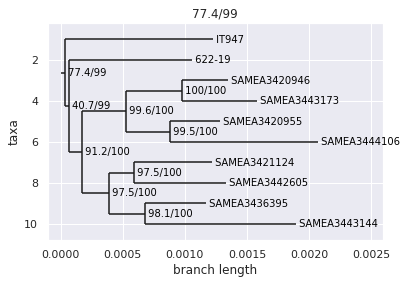

   ___________________________________ IT947
  |
  | _____________________________ 622-19
__||
  ||                           __________ SAMEA3420946
  ||             _____________|
  ||            |             |_________________ SAMEA3443173
   |   _________|
   |  |         |           ___________ SAMEA3420955
   |  |         |__________|
   |  |                    |____________________________________ SAMEA3444106
   |__|
      |             __________________ SAMEA3421124
      |      ______|
      |     |      |_____________________ SAMEA3442605
      |_____|
            |         ______________ SAMEA3436395
            |________|
                     |____________________________________ SAMEA3443144

38.290092196649994

63.816820327749994 - 127.63364065549999 years


In [118]:
clade_isolate_IDs = ['IT947','622-19','SAMEA3443144','SAMEA3436395','SAMEA3442605','SAMEA3421124','SAMEA3444106','SAMEA3420955','SAMEA3443173','SAMEA3420946']
print(len(clade_isolate_IDs))
est_TMRCA_for_isolates(clade_isolate_IDs)

Cluster **C** (Previously Cluster B), *double* mutant

4


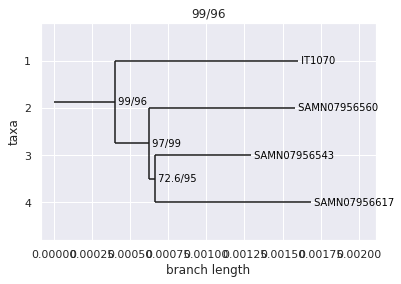

                 _____________________________________________ IT1070
________________|
                |         ___________________________________ SAMN07956560
                |________|
                         | _______________________ SAMN07956543
                         ||
                          |_______________________________________ SAMN07956617

35.681690282400005

59.46948380400001 - 118.93896760800003 years


In [119]:
clade_isolate_IDs = ['IT1070','SAMN07956560','SAMN07956617','SAMN07956543']
print(len(clade_isolate_IDs))
est_TMRCA_for_isolates(clade_isolate_IDs)

(Previously Cluster C)

7


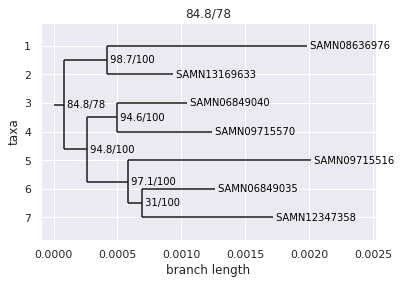

               _________________________________________________ SAMN08636976
    __________|
   |          |_______________ SAMN13169633
   |
___|             _________________ SAMN06849040
   |      ______|
   |     |      |_______________________ SAMN09715570
   |_____|
         |          _____________________________________________ SAMN09715516
         |_________|
                   |   __________________ SAMN06849035
                   |__|
                      |________________________________ SAMN12347358

35.602072407600005

59.33678734600001 - 118.67357469200002 years


In [120]:
clade_isolate_IDs = ['SAMN13169633','SAMN08636976','SAMN09715570','SAMN06849040','SAMN09715516','SAMN12347358','SAMN06849035']
print(len(clade_isolate_IDs))
est_TMRCA_for_isolates(clade_isolate_IDs)

Cluster **A** (Previously Cluster D), *single* mutant

3


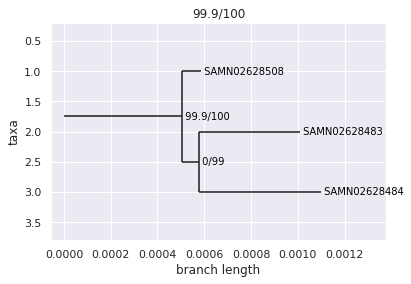

                               ____ SAMN02628508
______________________________|
                              |     ________________________ SAMN02628483
                              |____|
                                   |______________________________ SAMN02628484

15.108463940999998

25.180773234999997 - 50.36154646999999 years


In [121]:
clade_isolate_IDs = ['SAMN02628483','SAMN02628484','SAMN02628508']
print(len(clade_isolate_IDs))
est_TMRCA_for_isolates(clade_isolate_IDs)

(Previously Cluster E)

11


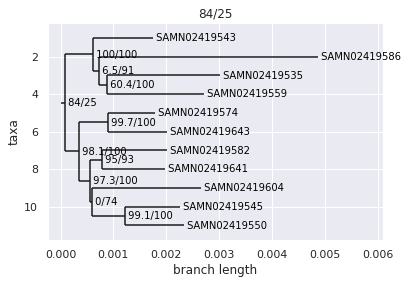

         ______________ SAMN02419543
  ______|
 |      |  _____________________________________________________ SAMN02419586
 |      |_|
 |        |  ___________________________ SAMN02419535
 |        |_|
_|          |_______________________ SAMN02419559
 |
 |           ___________ SAMN02419574
 |    ______|
 |   |      |_____________ SAMN02419643
 |   |
 |___|      ______________ SAMN02419582
     |   __|
     |  |  |______________ SAMN02419641
     |__|
        |__________________________ SAMN02419604
        |
        |        _____________ SAMN02419545
        |_______|
                |______________ SAMN02419550

65.6795937612

109.465989602 - 218.931979204 years


In [122]:
clade_isolate_IDs = ['SAMN02419545','SAMN02419550','SAMN02419604','SAMN02419582','SAMN02419641','SAMN02419574','SAMN02419643','SAMN02419535','SAMN02419559','SAMN02419586','SAMN02419543']
print(len(clade_isolate_IDs))
est_TMRCA_for_isolates(clade_isolate_IDs)

(Previously Cluster F)

2


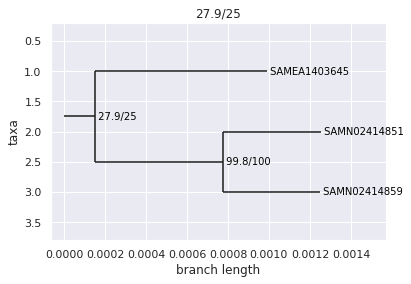

         ___________________________________________ SAMEA1403645
________|
        |                                 ________________________ SAMN02414851
        |________________________________|
                                         |_______________________ SAMN02414859

29.156750805

48.59458467500001 - 97.18916935000001 years


In [123]:
clade_isolate_IDs = ['SAMN02414859','SAMEA1403645']
print(len(clade_isolate_IDs))
est_TMRCA_for_isolates(clade_isolate_IDs)

Cluster **D** (Previously Cluster G), *double* mutant

3


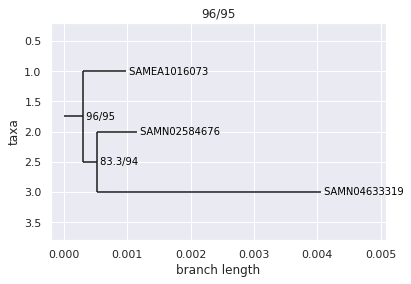

      __________ SAMEA1016073
_____|
     |    _________ SAMN02584676
     |___|
         |________________________________________________________ SAMN04633319

25.413067284

42.35511214 - 84.71022428 years


In [124]:
clade_isolate_IDs = ['SAMN02584676','SAMN04633319','SAMEA1016073']
print(len(clade_isolate_IDs))
est_TMRCA_for_isolates(clade_isolate_IDs)

(Previously Cluster H)

4


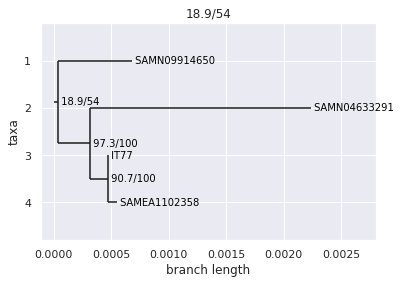

   _________________ SAMN09914650
__|
  |        _______________________________________________________ SAMN04633291
  |_______|
          |   , IT77
          |___|
              |__ SAMEA1102358

17.348828827800002

28.914714713000006 - 57.82942942600001 years


In [125]:
clade_isolate_IDs = ['IT77','SAMEA1102358','SAMN04633291','SAMN09914650']
print(len(clade_isolate_IDs))
est_TMRCA_for_isolates(clade_isolate_IDs)

Cluster **E** (Previously Cluster I), *double* mutant

8


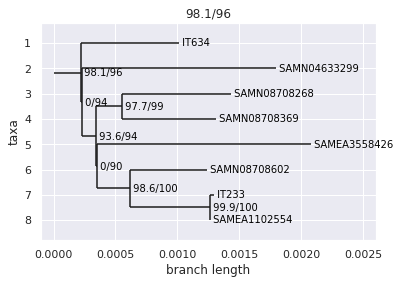

        ________________________ IT634
       |
_______|________________________________________________ SAMN04633299
       |
       |           __________________________ SAMN08708268
       |    ______|
       |   |      |______________________ SAMN08708369
       |___|
           |_____________________________________________________ SAMEA3558426
           |
           |         __________________ SAMN08708602
           |________|
                    |                  , IT233
                    |__________________|
                                       | SAMEA1102554

32.562752140049994

54.27125356674999 - 108.54250713349998 years


In [126]:
clade_isolate_IDs = ['IT233','SAMEA1102554','SAMN08708602','SAMEA3558426','SAMN08708268','SAMN08708369','SAMN04633299','IT634']
print(len(clade_isolate_IDs))
est_TMRCA_for_isolates(clade_isolate_IDs)

(Previously Cluster J)

4


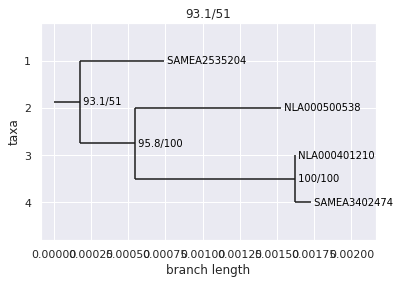

        ____________________ SAMEA2535204
_______|
       |              ____________________________________ NLA000500538
       |_____________|
                     |                                       , NLA000401210
                     |_______________________________________|
                                                             |____ SAMEA3402474

42.165309852600004

70.275516421 - 140.551032842 years


In [127]:
clade_isolate_IDs = ['NLA000401210','SAMEA3402474','NLA000500538','SAMEA2535204']
print(len(clade_isolate_IDs))
est_TMRCA_for_isolates(clade_isolate_IDs)

(Previously Cluster K)

3


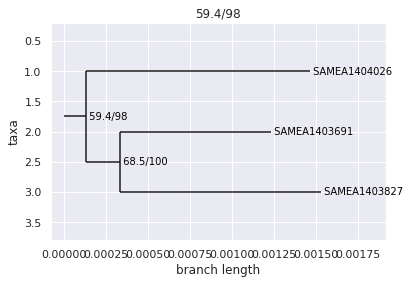

       ________________________________________________________ SAMEA1404026
______|
      |         _____________________________________ SAMEA1403691
      |________|
               |__________________________________________________ SAMEA1403827

39.9375745062

66.562624177 - 133.125248354 years


In [128]:
clade_isolate_IDs = ['SAMEA1403691','SAMEA1403827','SAMEA1404026']
print(len(clade_isolate_IDs))
est_TMRCA_for_isolates(clade_isolate_IDs)

Cluster **B** (Previously Cluster L), *single* mutant

2


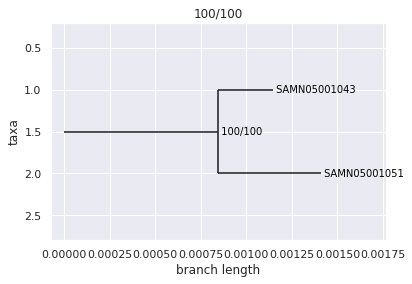

                                         _____________ SAMN05001043
________________________________________|
                                        |__________________________ SAMN05001051

13.18763756295

21.97939593825 - 43.9587918765 years


In [129]:
clade_isolate_IDs = ['SAMN05001043','SAMN05001051']
print(len(clade_isolate_IDs))
est_TMRCA_for_isolates(clade_isolate_IDs)

(Previously Cluster M)

2


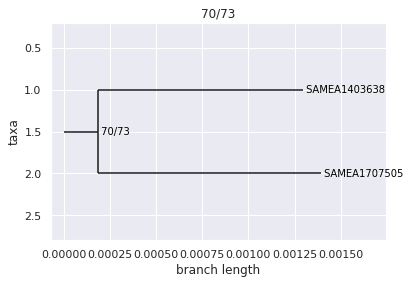

          ____________________________________________________ SAMEA1403638
_________|
         |_________________________________________________________ SAMEA1707505

35.040351325050004

58.40058554175001 - 116.80117108350002 years


In [130]:
clade_isolate_IDs = ['SAMEA1403638','SAMEA1707505']
print(len(clade_isolate_IDs))
est_TMRCA_for_isolates(clade_isolate_IDs)

Cluster **F** (Previously Cluster N), *double* mutant

2


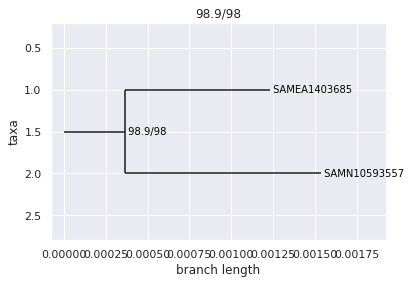

                 ____________________________________ SAMEA1403685
________________|
                |__________________________________________________ SAMN10593557

30.6063397143

51.0105661905 - 102.021132381 years


In [131]:
clade_isolate_IDs = ['SAMEA1403685','SAMN10593557']
print(len(clade_isolate_IDs))
est_TMRCA_for_isolates(clade_isolate_IDs)

# [7] Annotate new variants in additional 12 eis C-14T mutants with AG MICs in the *eis* gene

### Annotate INDELs w/ H37Rv Locus Info

#### Retrieve information for H37Rv Reference Genome

In [132]:
####################################################################################################################################################################################
#load reference genome and reference annotation
reference_genome = '/home/rv76/Farhat_Lab/Reference_Seqs/H37Rv/h37rv.fasta'
for reference_genome in SeqIO.parse(reference_genome, "fasta"):
    reference_genome.seq.alphabet = IUPAC.unambiguous_dna

reference_genome_annotation = pd.read_csv('/home/rv76/Farhat_Lab/CSV_files/h37rv_genome_summary.txt', '\t').set_index('name')

####### Make a dictionary of all H37Rv reference positions and corresponding genes #######
ReferencePosition_Gene_mapping = {} #keys: H37Rv Reference Positions , values: gene_ids (may be multiple genes for some Reference Positions)

#store a list corresponding to every Reference Position (to store all genes that map to the Reference Position)
for H37Rv_RefPos in range(0 , len(reference_genome.seq) + 1):
    ReferencePosition_Gene_mapping[H37Rv_RefPos] = []

for gene_id_index in range(0 , len(reference_genome_annotation.index)):

    gene_id_info = reference_genome_annotation.ix[gene_id_index , :]
    gene_id = gene_id_info.name

    chrom_start = gene_id_info.chromStart
    chrom_end = gene_id_info.chromEnd

    #find the position of the first base relative to H37Rv in 5' -> 3'
    H37Rv_start = min(chrom_start , chrom_end)
    H37Rv_end = max(chrom_start , chrom_end)

    #store all corresponding H37Rv Reference Positions to gene_id in dictionary
    for H37Rv_RefPos in range(H37Rv_start+1 , H37Rv_end+1):

        ReferencePosition_Gene_mapping[H37Rv_RefPos].append(gene_id) #append gene_id to list already in dict
        
####################################################################################################################################################################################

/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


#### Annotate INDELs

To annotate INDELs, we get gene_ids that the INDELs 'land in' and the gene-relative coordinate.

In [133]:
#load INDEL annotation file (rows of Genotype Matrix)
INDEL_annotation_DF = pd.DataFrame()
INDEL_annotation_DF.loc[:,'key'] = ['CCGGCGATGCGT_2715054_C', 'A_2714706_AC', 'C_2714933_CG']
INDEL_annotation_DF.loc[:,'pos'] = [2715054, 2714706, 2714933]
INDEL_annotation_DF.loc[:,'ref'] = ['CCGGCGATGCGT', 'A', 'C']
INDEL_annotation_DF.loc[:,'alt'] = ['C', 'AC', 'CG']

INDEL_annotation_DF.head()

,key,pos,ref,alt
0,CCGGCGATGCGT_2715054_C,2715054,CCGGCGATGCGT,C
1,A_2714706_AC,2714706,A,AC
2,C_2714933_CG,2714933,C,CG


In [134]:
np.shape(INDEL_annotation_DF)

(3, 4)

#### Gene Categories

In [135]:
#get Gene Categories
gene_categories = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/gene_categories/gene_categories.csv').set_index('name')

#create dictionary, keys: H37Rv locus, values: gene category
gene_categories_map = dict( zip( list(gene_categories.gene_id) , list(gene_categories.Gene_Category) ) ) 

#### Gene Names

Parse through Mycobrowser (tuberculist) to collect gene names

In [136]:
mycobrowser_table = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/Mycobrowser_Release3/Mycobacterium_tuberculosis_H37Rv_txt_v3.txt' , sep = '\t')

#retreive columns for locus tag & gene name
mycobrowser_table = mycobrowser_table.loc[: , ['Locus' , 'Name']]

#create dictionary, keys: H37Rv loucs, values: gene category
gene_names_map = dict( zip( list(mycobrowser_table.Locus) , list(mycobrowser_table.Name) ) ) 

#### Iterate through each INDEL to annotate

Some INDELs are present in more than 1 gene, have to account for this

In [137]:
#create dictionaries for each columsn of information
locus_tag_dict = {} #H37Rv id
genomic_coord_dict = {} #coordinate on gene, 5' -> 3'
gene_categ_dict = {} #gene Category
gene_name_dict = {} #gene Name

for INDEL_index in INDEL_annotation_DF.index:

    #reference position, ref allele and alt allele for INDEL
    INDEL_info = INDEL_annotation_DF.loc[INDEL_index , :]

    #find the gene that INDEL occurs on
    ref_seq_position = INDEL_info.pos

    #check list corresponding to H37Rv coordinate to see if there are any genes associated with RefPosition
    if len(ReferencePosition_Gene_mapping[ref_seq_position]) == 1:
        
        #get gene that ReferencePosition is mapped to (i.e. INDEL filtering ensures that INDEL corresponds to only 1 gene)
        gene_intergenic_id = ReferencePosition_Gene_mapping[ref_seq_position][0]

        #find genomic coordinate of INDEL relative to gene (subtract 1 since reference seq starts counting at 1)
        gene_relative_coord = (ref_seq_position - 1) - min( reference_genome_annotation.loc[gene_intergenic_id , 'chromStart'] , reference_genome_annotation.loc[gene_intergenic_id , 'chromEnd'] )

        #store all information for INDEL in relevant dictionaries
        locus_tag_dict[INDEL_index] = gene_intergenic_id
        genomic_coord_dict[INDEL_index] = gene_relative_coord

        #use gene id to get category and names from mappings
        if gene_intergenic_id in gene_categories_map.keys():
            gene_categ_dict[INDEL_index] = gene_categories_map[gene_intergenic_id]
        else:
            gene_categ_dict[INDEL_index] = 'None'

        if gene_intergenic_id in gene_names_map.keys():
            gene_name_dict[INDEL_index] = gene_names_map[gene_intergenic_id] 
        else:
            gene_name_dict[INDEL_index] = 'None'
            
    #H37Rv RefSeq position was not found in dictionary so Reference position must be intergenic    
    elif len(ReferencePosition_Gene_mapping[ref_seq_position]) == 0:

        #store all information for INDEL in relevant dictionaries
        locus_tag_dict[INDEL_index] = 'intergenic'
        genomic_coord_dict[INDEL_index] = np.nan
        gene_categ_dict[INDEL_index] = 'None'
        gene_name_dict[INDEL_index] = 'None'

    #keep track of progress of loop
    num_INDELs = float( np.shape(INDEL_annotation_DF)[0] )
    if INDEL_index % np.ceil(0.20 * num_INDELs) == 0:
        print float(INDEL_index) / num_INDELs

0.0
0.333333333333
0.666666666667


#### Update INDEL annotation DF

In [138]:
#append columns for info from annotation
INDEL_annotation_DF['gene_id'] = pd.Series(locus_tag_dict)
INDEL_annotation_DF['gene_pos'] = pd.Series(genomic_coord_dict)
INDEL_annotation_DF['gene_category'] = pd.Series(gene_categ_dict)
INDEL_annotation_DF['gene_name'] = pd.Series(gene_name_dict)

In [139]:
np.shape( INDEL_annotation_DF )

(3, 8)

In [140]:
INDEL_annotation_DF.head()

,key,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name
0,CCGGCGATGCGT_2715054_C,2715054,CCGGCGATGCGT,C,Rv2416c,930,Non-Essential,eis
1,A_2714706_AC,2714706,A,AC,Rv2416c,582,Non-Essential,eis
2,C_2714933_CG,2714933,C,CG,Rv2416c,809,Non-Essential,eis


### This block of code will determine the functional consequence of each INDEL in our genotypes array.

#### Create a dataframe for each unique _reference_ allele - _alternate_ allele pairing

In [141]:
INDEL_functional_annotation_DF = INDEL_annotation_DF.loc[: , ['key' , 'pos' , 'ref' , 'alt' , 'gene_category' , 'gene_name']]
INDEL_functional_annotation_DF.set_index('key' , inplace = True , drop = True)

In [142]:
INDEL_functional_annotation_DF.head()

,pos,ref,alt,gene_category,gene_name
key,,,,,
CCGGCGATGCGT_2715054_C,2715054,CCGGCGATGCGT,C,Non-Essential,eis
A_2714706_AC,2714706,A,AC,Non-Essential,eis
C_2714933_CG,2714933,C,CG,Non-Essential,eis


In [143]:
np.shape(INDEL_functional_annotation_DF)

(3, 5)

Convert **gene_category** and **gene_name** columns so that the elements are lists only when there is more than 1 label in a cell (when a Reference Position corresponds to two overlapping genes, these positions have been filtered out in the most recent version of analysis)

In [144]:
gene_category_list = []
gene_name_list = []

for INDEL_i in INDEL_functional_annotation_DF.index:
    
    gene_category_INDEL_i = INDEL_functional_annotation_DF.loc[INDEL_i , 'gene_category']
    gene_name_INDEL_i = INDEL_functional_annotation_DF.loc[INDEL_i , 'gene_name']
    
    if len(gene_category_INDEL_i) == 1:
        
        gene_category_list.append(gene_category_INDEL_i[0])
        gene_name_list.append(gene_name_INDEL_i[0])
    
    else:
        
        gene_category_list.append(gene_category_INDEL_i)
        gene_name_list.append(gene_name_INDEL_i)
        
INDEL_functional_annotation_DF['gene_category'] = gene_category_list
INDEL_functional_annotation_DF['gene_name'] = gene_name_list

In [145]:
INDEL_functional_annotation_DF.head()

,pos,ref,alt,gene_category,gene_name
key,,,,,
CCGGCGATGCGT_2715054_C,2715054,CCGGCGATGCGT,C,Non-Essential,eis
A_2714706_AC,2714706,A,AC,Non-Essential,eis
C_2714933_CG,2714933,C,CG,Non-Essential,eis


In [146]:
np.shape(INDEL_functional_annotation_DF)

(3, 5)

#### Load in work-horse for functional INDEL annotation

Relevant Information for H37Rv sequence and INDEL functional annotation

In [147]:
####### Collect all DNA and Amino Acid sequences corresponding to genes on H37Rv #######
#load reference genome and reference annotation
reference_genome = '/n/data1/hms/dbmi/farhat/bin/work-horse/bin/h37rv.fasta'
for reference_genome in SeqIO.parse(reference_genome, "fasta"):
    reference_genome.seq.alphabet = IUPAC.unambiguous_dna

reference_genome_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/h37rv_genome_summary.txt', '\t').set_index('name')

####### Load in dictionaries for SNP annotation #######
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/pickled_files/dicts_for_SNP_annotation/H37Rv_gene_seq_records.pickle', 'rb') as handle:
    ref_gene_sequences_records = pickle.load(handle)
    
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/pickled_files/dicts_for_SNP_annotation/H37Rv_protein_seq_records.pickle', 'rb') as handle:
    ref_protein_sequences_records = pickle.load(handle)
    
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/pickled_files/dicts_for_SNP_annotation/H37Rv_coord_gene_mapping.pickle', 'rb') as handle:
    ReferencePosition_Gene_mapping = pickle.load(handle)

Function to annotate Intergenic INDELs

In [148]:
def find_flanking_genes_for_intergenic_region(intergenic_ref_pos): 

    #this function finds the genes flagging an intergenic region given a reference position

    #find gene immediately in the 5' direction
    for i in range(0 , 100000):

        #move toward 5' direction
        if ReferencePosition_Gene_mapping[intergenic_ref_pos - i] != []:

            gene_to_left = ReferencePosition_Gene_mapping[intergenic_ref_pos - i][0]
            break

    #find gene immediately in the 3' direction       
    for i in range(0 , 100000):

        #move toward 3' direction
        try:
            if ReferencePosition_Gene_mapping[intergenic_ref_pos + i] != []:

                gene_to_right = ReferencePosition_Gene_mapping[intergenic_ref_pos + i][0]
                break
        
        #KeyError means we have hit the 'end' of the chromosome, the intergenic region at then end of H37Rv in 5' > 3' orientation 
        #since TB chromosome is circular the gene to the 'right' is Rv0001    
        except KeyError:
            
            gene_to_right = 'Rv0001'
            break
    
    return gene_to_left + '_' + gene_to_right

Function to determine whether INDELs are *Inframe* or *Frameshift*; Return codon position

In [149]:
def INDEL_type(ref_allele_i , ref_seq_position , alt_allele_i):
    
    '''
    This function takes as input a reference position on H37Rv located within a 
    gene, a reference allelel and an alternate allele and returns whether the indel
    would correspond to an inframe or frameshift indel.
    
    '''
    gene_intergenic_id_list = []
    genomic_coord_list = []
    IF_FS_list = []
    INS_DEL_list = []
    codon_coord_list = []
    
    #find the gene that INDEL occurs on
    
    #check list corresponding to H37Rv coordinate to see if there are any genes associated with RefPosition
    if len(ReferencePosition_Gene_mapping[ref_seq_position]) > 0:

        #iterate through all genes that ReferencePosition is mapped to (i.e. SNP might correspond to 2 genes)
        for gene_intergenic_id in ReferencePosition_Gene_mapping[ref_seq_position]:

            #find genomic coordinate of SNP relative to gene (subtract 1 since reference seq starts counting at 1)
            gene_relative_coord = (ref_seq_position - 1) - min( reference_genome_annotation.loc[gene_intergenic_id , 'chromStart'] , reference_genome_annotation.loc[gene_intergenic_id , 'chromEnd'] )

            #find out if indel is inframe or frameshift
            indel_length = abs(len(ref_allele_i) - len(alt_allele_i))
            
            if indel_length % 3 == 0:
                INDEL_type = 'inframe'
                
            elif indel_length % 3 != 0:
                INDEL_type = 'frameshift'
                
            #find out whether insertion or deletion
            if len(ref_allele_i) > len(alt_allele_i):
                INS_or_DEL = 'del'
                
            elif len(ref_allele_i) < len(alt_allele_i):
                INS_or_DEL = 'ins'
            
            #get the codon number where the SNP occurs within
            ## take the genomic coordinate (relative to the gene, in the 5' to 3' direction), divide by 3, then take the ceiling of this number (will be fraction if SNP occurs in 1st or 2nd position on codon)
            strand = reference_genome_annotation.loc[gene_intergenic_id, 'strand']
            if strand == '+':
                 genomic_5_to_3_coord = (ref_seq_position) - reference_genome_annotation.loc[gene_intergenic_id , 'chromStart']

            elif strand == '-':
                 genomic_5_to_3_coord = (reference_genome_annotation.loc[gene_intergenic_id , 'chromEnd']) - (ref_seq_position-1)

            codon_coord = int(np.ceil( float( genomic_5_to_3_coord) / 3.0 ))
            
            #store relevant info in lists    
            gene_intergenic_id_list.append(gene_intergenic_id)
            genomic_coord_list.append(genomic_5_to_3_coord)
            IF_FS_list.append(INDEL_type)
            INS_DEL_list.append(INS_or_DEL)
            codon_coord_list.append(codon_coord)
    
    #if no gene in H37Rv corresponds to the Reference Position for INDEL, then INDEL must be intergenic
    else:
        
        gene_intergenic_id = find_flanking_genes_for_intergenic_region(ref_seq_position)
        
        #find out if indel is inframe or frameshift
        indel_length = abs(len(ref_allele_i) - len(alt_allele_i))

        if indel_length % 3 == 0:
            INDEL_type = 'inframe'

        elif indel_length % 3 != 0:
            INDEL_type = 'frameshift'
            
        #find out whether insertion or deletion
        if len(ref_allele_i) > len(alt_allele_i):
            INS_or_DEL = 'del'

        elif len(ref_allele_i) < len(alt_allele_i):
            INS_or_DEL = 'ins'
                
        genomic_5_to_3_coord = 'None'
        codon_coord = 'None'
        
        #store relevant info in lists    
        gene_intergenic_id_list.append(gene_intergenic_id)
        genomic_coord_list.append('None')
        IF_FS_list.append('I')
        INS_DEL_list.append(INS_or_DEL)
        codon_coord_list.append('None')
    
    #if there is only a single gene associated with this INDEL, just return the individual elememts
    if len(gene_intergenic_id_list) == 1:
        return [gene_intergenic_id , genomic_5_to_3_coord , INS_or_DEL , INDEL_type , codon_coord]
    
    #else if there are two genes associated with this SNP, return elements for each SNP annotation in a list
    elif len(gene_intergenic_id_list) > 1:
        return [gene_intergenic_id_list , genomic_coord_list , INS_DEL_list , IF_FS_list , codon_coord_list]

#### Iterate through each unique Reference Allele - Alternate Allele pair and get relevant annotation

In [150]:
#create lists for each new column of the INDEL functional annotation DF
gene_intergenic_id_list = []
gene_pos_list = []
INS_DEL_list = []
INDEL_type_list = []
codon_coord_list = []

for INDEL_i in INDEL_functional_annotation_DF.index:
    
    #get the reference allele , reference position & alternate allele from index key
    ref_allele_i , ref_pos_i , alt_allele_i = INDEL_i.split('_')
    
    #get functional annotation for INDEL
    gene_intergenic_id_i , gene_pos_i , INS_or_DEL_i , INDEL_type_i , codon_coord_i = INDEL_type(ref_allele_i , int(ref_pos_i) , alt_allele_i)
    
    #store functional annotation info in lists
    gene_intergenic_id_list.append(gene_intergenic_id_i)
    gene_pos_list.append(gene_pos_i)
    INS_DEL_list.append(INS_or_DEL_i)
    INDEL_type_list.append(INDEL_type_i)
    codon_coord_list.append(codon_coord_i)
    
#append new columns to INDEL functional annotation
INDEL_functional_annotation_DF['gene_id'] = gene_intergenic_id_list
INDEL_functional_annotation_DF['gene_pos'] = gene_pos_list
INDEL_functional_annotation_DF['ins_del'] = INS_DEL_list
INDEL_functional_annotation_DF['INDEL_type'] = INDEL_type_list
INDEL_functional_annotation_DF['codon_pos'] = codon_coord_list

In [151]:
np.shape(INDEL_functional_annotation_DF)

(3, 10)

In [152]:
INDEL_functional_annotation_DF.head()

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos
key,,,,,,,,,,
CCGGCGATGCGT_2715054_C,2715054,CCGGCGATGCGT,C,Non-Essential,eis,Rv2416c,279,del,frameshift,93
A_2714706_AC,2714706,A,AC,Non-Essential,eis,Rv2416c,627,ins,frameshift,209
C_2714933_CG,2714933,C,CG,Non-Essential,eis,Rv2416c,400,ins,frameshift,134


__Note__: 

The gene position/coordinate for the original INDEL annotation file (whose rows map to the rows of the Genotypes Matrix) starts counting from 0, this is to accomodate the functional INDEL annotation. 

The gene position/coordinate for the functional INDEL annotation (above) starts counting from 1 which is more intuitive for reporting purposes.